# Structural Analysis of the Interface

1. Import Statements
2. Data Preparation
3. Structural Feature Analysis (Surface Area, H-Bonds, Salt-Bridges, Binding Score)
4. Sequence Analysis 

## Import Statements

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import random
import os
from pymol import cmd
from collections import defaultdict, Counter 
from sklearn.preprocessing import MinMaxScaler
from Bio.SeqUtils import seq1
from Bio import SeqIO 
from Bio import pairwise2
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram

import matplotlib.cm as cm
from scipy.stats import kruskal
from itertools import combinations
from scipy.stats import mannwhitneyu



plt.rcParams['font.family'] = 'Calibri'
plt.rcParams['axes.titleweight'] = 'bold'


/opt/anaconda3/envs/epitope_env/lib/python3.10/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


## Data Preparation

### Read given Checkpoint PDB ID information

In [2]:
# Define datasets for individual inhibitory checkpoints
data = pd.read_csv('data/ab_ag.tsv', sep='\t')
pd1 = data[data['compound'].str.contains('PD-1', na=False)]
pdl1 = data[data['compound'].str.contains('PD-L1', na=False)]
ctla4 = data[data['compound'].str.contains('CTLA-4', na=False)]
kir = data[data['compound'].str.contains('KIR', na=False)]
lag3 = data[data['compound'].str.contains('LAG', na=False)]
tim3 = data[data['compound'].str.contains('TIM3', na=False)]

In [3]:
# Filter out necessary columns
pd1 = pd1[['pdb', 'Hchain', 'Lchain', 'antigen_chain', 'antigen_type', 'antigen_name', 'compound', 'resolution', 'method']]
pdl1 = pdl1[['pdb', 'Hchain', 'Lchain', 'antigen_chain', 'antigen_type', 'antigen_name', 'compound', 'resolution', 'method']]
ctla4 = ctla4[['pdb', 'Hchain', 'Lchain', 'antigen_chain', 'antigen_type', 'antigen_name', 'compound', 'resolution', 'method']]
kir = kir[['pdb', 'Hchain', 'Lchain', 'antigen_chain', 'antigen_type', 'antigen_name', 'compound', 'resolution', 'method']]
lag3 = lag3[['pdb', 'Hchain', 'Lchain', 'antigen_chain', 'antigen_type', 'antigen_name', 'compound', 'resolution', 'method']]
tim3 = tim3[['pdb', 'Hchain', 'Lchain', 'antigen_chain', 'antigen_type', 'antigen_name', 'compound', 'resolution', 'method']]

In [4]:
combined_dataset = [pdl1, pd1, ctla4, kir, lag3, tim3]

# Shuffle the list randomly
random.shuffle(combined_dataset)

# Concatenate them in the new random order
merged_df = pd.concat(combined_dataset, ignore_index=True)
shuffled_df = merged_df.sample(frac=1).reset_index(drop=True)

In [5]:
shuffled_df = shuffled_df[shuffled_df['resolution'] < 3.5]
shuffled_df = shuffled_df.dropna()

### Extract and Clean Antibody-Checkpoint Associations

In [6]:
# 1. Filter all relevant rows: those with 'mab' OR 'M6903'
ab_mask = shuffled_df['compound'].str.contains('mab|M6903', na=False, case=False)
shuffled_df_ab = shuffled_df[ab_mask]

# 2. Extract antibody names
shuffled_df_ab['antibody'] = shuffled_df_ab['compound'].str.extract(r'\b(\w*mab)\b', expand=False)

# 3. Fill in M6903 manually where missing
m6903_mask = shuffled_df_ab['compound'].str.contains('M6903', na=False)
shuffled_df_ab.loc[m6903_mask, 'antibody'] = shuffled_df_ab.loc[m6903_mask, 'antibody'].fillna('M6903')

# # 4. Extract checkpoint names
checkpoints_pattern = r'\b(PD-1|PD-L1|CTLA-4|KIR2DL3|TIM3)\b'
shuffled_df_ab['checkpoint'] = shuffled_df_ab['compound'].str.extract(checkpoints_pattern, expand=False)

# # 5. Final formatting
shuffled_df_ab = shuffled_df_ab[['antibody', 'checkpoint', 'pdb', 'Hchain', 'Lchain', 'antigen_chain']]
shuffled_df_ab['antibody'] = shuffled_df_ab['antibody'].str.upper()

shuffled_df_ab

/var/folders/vf/ygq5vvrx3fbcsv9n_5277nmr0000gn/T/ipykernel_42590/60524799.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shuffled_df_ab['antibody'] = shuffled_df_ab['compound'].str.extract(r'\b(\w*mab)\b', expand=False)
/var/folders/vf/ygq5vvrx3fbcsv9n_5277nmr0000gn/T/ipykernel_42590/60524799.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shuffled_df_ab['checkpoint'] = shuffled_df_ab['compound'].str.extract(checkpoints_pattern, expand=False)


,antibody,checkpoint,pdb,Hchain,Lchain,antigen_chain
0,IPILIMUMAB,CTLA-4,5xj3,D,E,F
1,PEMBROLIZUMAB,PD-1,5jxe,G,F,A
2,ATEZOLIZUMAB,PD-L1,5x8l,G,L,B
3,TISLELIZUMAB,PD-1,7cgw,A,B,C
4,IPILIMUMAB,CTLA-4,5xj3,A,B,C
5,CAMRELIZUMAB,PD-1,7cu5,B,B,E
6,ATEZOLIZUMAB,PD-L1,5x8l,H,M,C
8,M6903,TIM3,6txz,K,O,D
10,NaN,NaN,6k0y,A,B,C
14,ATEZOLIZUMAB,PD-L1,5x8l,S,N,D


In [7]:
pdb_list = shuffled_df_ab['pdb'].unique().tolist()

In [8]:
# make a list of the columns 
shuffled_df_ab = shuffled_df_ab[['pdb', 'Hchain', 'Lchain', 'antigen_chain']]
extracted_list = shuffled_df_ab.values.tolist()

extracted_list


[['5xj3', 'D', 'E', 'F'],
 ['5jxe', 'G', 'F', 'A'],
 ['5x8l', 'G', 'L', 'B'],
 ['7cgw', 'A', 'B', 'C'],
 ['5xj3', 'A', 'B', 'C'],
 ['7cu5', 'B', 'B', 'E'],
 ['5x8l', 'H', 'M', 'C'],
 ['6txz', 'K', 'O', 'D'],
 ['6k0y', 'A', 'B', 'C'],
 ['5x8l', 'S', 'N', 'D'],
 ['5ggr', 'A', 'B', 'Y'],
 ['5tru', 'h', 'l', 'c'],
 ['7bxa', 'H', 'L', 'P'],
 ['5b8c', 'B', 'A', 'C'],
 ['5b8c', 'H', 'G', 'I'],
 ['5x8m', 'B', 'C', 'A'],
 ['5grj', 'H', 'L', 'A'],
 ['5tru', 'H', 'L', 'C'],
 ['7cu5', 'A', 'A', 'Q'],
 ['8gy5', 'H', 'L', 'P'],
 ['5ggs', 'A', 'B', 'Z'],
 ['5xxy', 'H', 'L', 'A'],
 ['5xj3', 'G', 'H', 'I'],
 ['5ggs', 'C', 'D', 'Y'],
 ['7su0', 'H', 'L', 'C'],
 ['9dq4', 'H', 'L', 'A'],
 ['6txz', 'J', 'N', 'C'],
 ['6rp8', 'H', 'L', 'C'],
 ['7su0', 'I', 'M', 'D'],
 ['7wvm', 'C', 'D', 'F'],
 ['5ggr', 'H', 'L', 'Z'],
 ['5xj3', 'J', 'K', 'L'],
 ['8tui', 'H', 'L', 'A'],
 ['6txz', 'I', 'M', 'B'],
 ['9dq3', 'H', 'L', 'C'],
 ['8gy5', 'A', 'B', 'Q'],
 ['5ggv', 'H', 'L', 'Y'],
 ['7su1', 'H', 'L', 'C'],
 ['6rp8', 'h

## Structural Feature Analysis 

### Surface Area, Hydrogen-Bonds and Saltbridges Extraction

In [9]:
section = 'paratope' 
root_folder = "structures"
cutoff_distance = 5.0
hbond_cutoff = 3.5
salt_cutoff = 4.0
bsa_threshold = 0.1

results = []

# Define interacting partners based on section
def get_partner_chains(h_chain, l_chain, ag_chain, section):
    if section == 'paratope':
        source_chain = f"{h_chain}+{l_chain}"
        target_chain = ag_chain
    elif section == 'epitope':
        source_chain = ag_chain
        target_chain = f"{h_chain}+{l_chain}"
    return source_chain, target_chain


for pdb_id, h_chain, l_chain, ag_chain in extracted_list:
    pdb_path = None
    for dirpath, _, filenames in os.walk(root_folder):
        for file in filenames:
            if file.lower() == f"{pdb_id.lower()}.pdb":
                pdb_path = os.path.join(dirpath, file)
                break
        if pdb_path:
            break

    if not pdb_path:
        print(f"Skipping {pdb_id}: PDB file not found")
        continue

    print(f"\n Processing {pdb_id} ({section})...")
    cmd.reinitialize()
    cmd.bg_color("white")
    cmd.load(pdb_path)

    source_chain, target_chain = get_partner_chains(h_chain, l_chain, ag_chain, section)

    # Define antigen selection for coloring
    if section == "epitope":
        cmd.select("antigen", f"chain {ag_chain}")
    else:
        cmd.select("antibody", f"chain {source_chain}")
        
    # Define selections
    cmd.select("source", f"chain {source_chain}")
    cmd.select("target", f"chain {target_chain}")
    cmd.select(section, f"source within {cutoff_distance} of target")

    # Color antibody chains 
    cmd.color("violet", f"chain {h_chain}")
    cmd.color("violet", f"chain {l_chain}")

    # Color antigen chain 
    cmd.color("teal", f"chain {ag_chain}")

    # Highlight paratope/epitope
    cmd.color("yellow", f"{section}")

    buried_residues = []
    if cmd.count_atoms(section) == 0:
        print(" No atoms found, skipping BSA")
        num_hbonds_filtered = 0
    else:
        residue_set = set()
        model = cmd.get_model(section)
        for atom in model.atom:
            residue_set.add((atom.chain, atom.resi))

        for chain, resi in residue_set:
            resid_sel = f"(chain {chain} and resi {resi})"
            try:
                # Create source-only object (no target)
                cmd.create("source_only", f"chain {source_chain}")
                cmd.select("res_in_source_only", f"source_only and chain {chain} and resi {resi}")
                cmd.get_area("res_in_source_only", load_b=1)
                sasa_free = sum([a.b for a in cmd.get_model("res_in_source_only").atom])
                cmd.delete("source_only")
                cmd.delete("res_in_source_only")

                # SASA in complex
                cmd.get_area(resid_sel, load_b=1)
                sasa_complex = sum([a.b for a in cmd.get_model(resid_sel).atom])
                bsa = sasa_free - sasa_complex

                print(f"   Residue {chain}:{resi} — BSA={bsa:.2f}")
                if bsa > bsa_threshold:
                    buried_residues.append((chain, resi))

            except Exception as e:
                print(f" Error {chain}:{resi} → {e}")
                continue

        if buried_residues:
            buried_sel = " or ".join([f"(chain {c} and resi {r})" for c, r in buried_residues])
            cmd.select(f"buried_{section}", buried_sel)

    

            # Filtered H-bonds
            hbonds_filtered = cmd.find_pairs(f"buried_{section}", "target", mode=1, cutoff=hbond_cutoff)
            num_hbonds_filtered = len(hbonds_filtered)
            print(f" Filtered H-bonds: {num_hbonds_filtered}")
        else:
            print(" No buried residues found.")
            num_hbonds_filtered = 0

    # SASA area of selections
    try:
        buried_area = cmd.get_area(f"buried_{section}")
    except:
        buried_area = 0.0
    try:
        total_area = cmd.get_area(section)
    except:
        total_area = 0.0

    print(f" {section.capitalize()} SASA: {total_area:.2f} Å²")

    # Salt bridges from buried residues only
    if buried_residues:
        cmd.select("acidic_buried", f"buried_{section} and resn ASP+GLU and name OD1+OD2+OE1+OE2")
        cmd.select("basic_target", f"target and resn LYS+ARG+HIS and name NZ+NH1+NH2+ND1+NE2")
        sb1 = cmd.find_pairs("acidic_buried", "basic_target", cutoff=salt_cutoff, mode=1)

        cmd.select("acidic_target", f"target and resn ASP+GLU and name OD1+OD2+OE1+OE2")
        cmd.select("basic_buried", f"buried_{section} and resn LYS+ARG+HIS and name NZ+NH1+NH2+ND1+NE2")
        sb2 = cmd.find_pairs("acidic_target", "basic_buried", cutoff=salt_cutoff, mode=1)

        for sel in ("acidic_buried", "basic_target", "acidic_target", "basic_buried"):
            cmd.delete(sel)

        num_salt_bridges = len(sb1) + len(sb2)
        print(f" Salt bridges (buried): {num_salt_bridges}")
    else:
        num_salt_bridges = 0
        print(f" Salt bridges skipped")

    # Save session
    session_out = os.path.join(dirpath, f"{pdb_id}_{section}.pse")
    cmd.save(session_out)

    # Save result
    results.append({
        "pdb_id": pdb_id,
        "H_chain": h_chain,
        "L_chain": l_chain,
        "antigen_chain": ag_chain,
        f"buried_{section}_area": buried_area,
        "num_filtered_hbonds": num_hbonds_filtered,
        "num_salt_bridges": num_salt_bridges,
        "folder": os.path.basename(dirpath)
    })

# Export results
output_dir = f"data/structural_analysis/{section.capitalize()}"
os.makedirs(output_dir, exist_ok=True)
output_file = os.path.join(output_dir, f"{section}_hbonds_salt_bridges_summary.csv")
df = pd.DataFrame(results)
df.to_csv(output_file, index=False)
print(f"\n Results saved to '{output_file}'")



 Processing 5xj3 (paratope)...
   Residue E:93 — BSA=1.62
   Residue D:102 — BSA=0.00
   Residue D:100 — BSA=0.00
   Residue D:56 — BSA=0.00
   Residue D:54 — BSA=0.00
   Residue E:92 — BSA=0.00
   Residue E:95 — BSA=1.68
   Residue D:53 — BSA=1.14
   Residue E:97 — BSA=0.00
   Residue D:50 — BSA=0.00
   Residue E:27 — BSA=0.00
   Residue D:103 — BSA=0.00
   Residue D:52 — BSA=0.00
   Residue E:32 — BSA=0.00
   Residue D:101 — BSA=1.24
   Residue E:50 — BSA=0.00
   Residue D:33 — BSA=0.00
   Residue E:28 — BSA=0.00
   Residue D:59 — BSA=3.77
   Residue D:31 — BSA=0.00
   Residue D:57 — BSA=1.29
   Residue E:94 — BSA=0.68
   Residue E:33 — BSA=0.00
 Filtered H-bonds: 17
 Paratope SASA: 1238.65 Å²
 Salt bridges (buried): 0

 Processing 5jxe (paratope)...
   Residue F:34 — BSA=0.00
   Residue F:31 — BSA=0.00
   Residue G:102 — BSA=0.55
   Residue F:95 — BSA=0.00
   Residue F:97 — BSA=0.00
   Residue G:54 — BSA=1.05
   Residue G:55 — BSA=0.00
   Residue F:100 — BSA=0.00
   Residue G:58 — 

In [10]:
df_struc_info = pd.read_csv(f"data/structural_analysis/{section.capitalize()}/{section}_hbonds_salt_bridges_summary.csv")
print(df_struc_info['pdb_id'].value_counts())

pdb_id
5x8l    5
5xj3    4
5b8c    4
6txz    4
7cgw    2
5jxe    2
5ggr    2
7cu5    2
7bxa    2
5tru    2
5ggs    2
8gy5    2
7wvm    2
7su0    2
6rp8    2
6k0y    1
5x8m    1
5grj    1
5xxy    1
9dq4    1
8tui    1
9dq3    1
5ggv    1
7su1    1
5wt9    1
7wsl    1
6xkr    1
5xj4    1
Name: count, dtype: int64


### Visualizing Structural Features

#### barplot - surface area 

findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: F

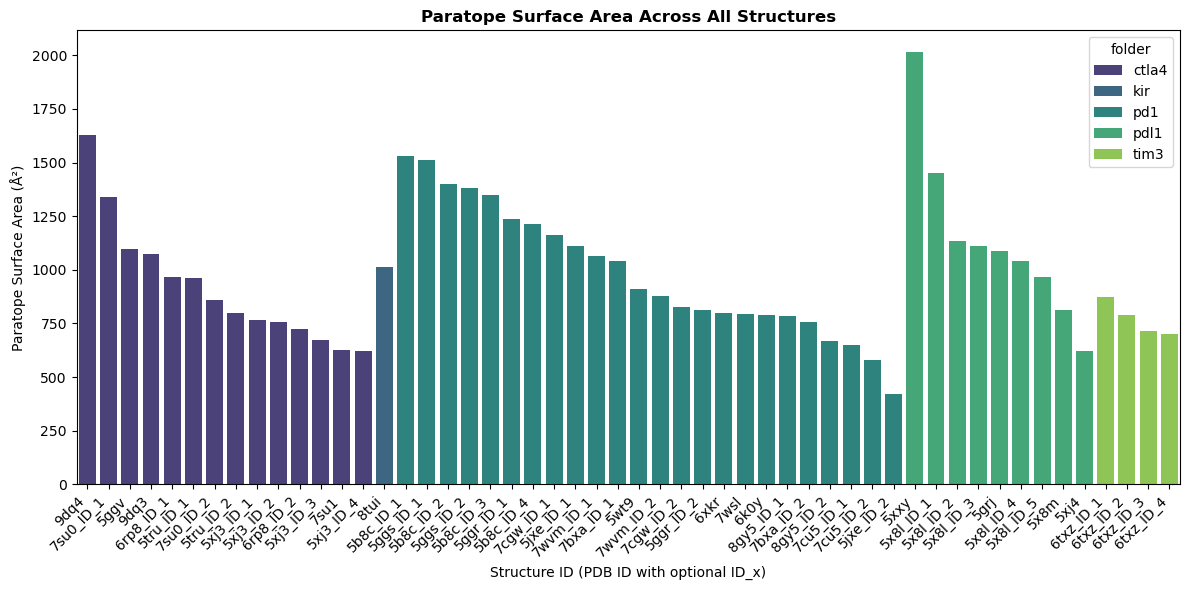

In [11]:
area = f"buried_{section}_area"
df_sorted = df_struc_info.sort_values(by=["folder", area], ascending=[True, False]).copy()

# Count how many times each pdb_id appears
id_frequencies = Counter(df_sorted["pdb_id"])
id_tracker = defaultdict(int)

# Build structure_id column
structure_ids = []

for pdb_id in df_sorted["pdb_id"]:
    if id_frequencies[pdb_id] == 1:
        structure_ids.append(pdb_id)
    else:
        id_tracker[pdb_id] += 1
        structure_ids.append(f"{pdb_id}_ID_{id_tracker[pdb_id]}")

df_sorted["structure_id"] = structure_ids

# Plotting (same as before)
plt.figure(figsize=(12, 6))
sns.barplot(data=df_sorted, x="structure_id", y=f"buried_{section}_area", hue="folder", dodge=False, palette="viridis")

plt.title(f"{section.capitalize()} Surface Area Across All Structures")
plt.xlabel("Structure ID (PDB ID with optional ID_x)")
plt.ylabel(f"{section.capitalize()} Surface Area (Å²)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig(f'plots/structural_analysis/{section.capitalize()}/{section}_surface_area_across_all_structures.pdf', bbox_inches='tight')
plt.show()



#### Scatter Plot - Hydrogen Bonds vs Surface Area

findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: F

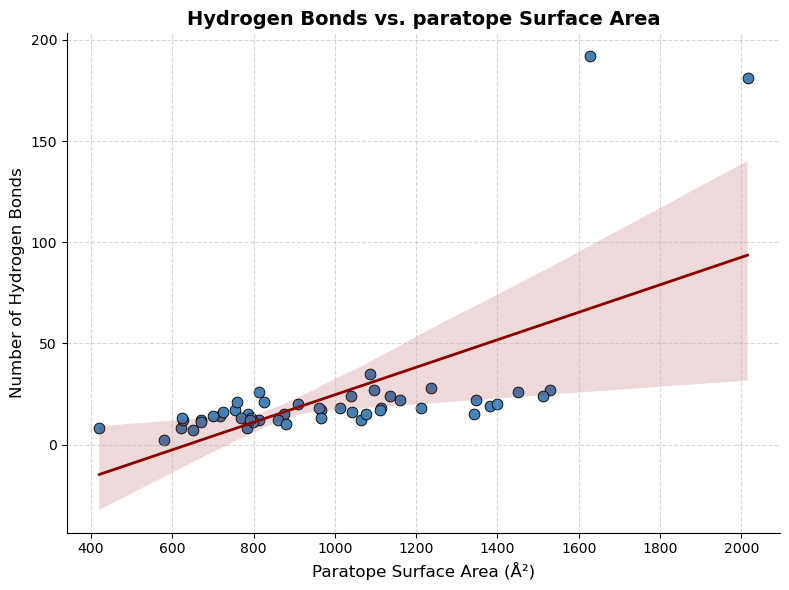

In [12]:
plt.figure(figsize=(8, 6))

# Scatterplot
sns.scatterplot(
    data=df_struc_info,
    x=f"buried_{section}_area",
    y="num_filtered_hbonds",
    s=60,
    color="steelblue",
    edgecolor="black"
)

# Regression line
sns.regplot(
    data=df_struc_info,
    x=f"buried_{section}_area",
    y="num_filtered_hbonds",
    scatter=False,
    color="darkred",
    line_kws={'linewidth': 2}
)

# Styling
plt.title(f"Hydrogen Bonds vs. {section} Surface Area", fontsize=14, fontweight="bold")
plt.xlabel(f"{section.capitalize()} Surface Area (Å²)", fontsize=12)
plt.ylabel("Number of Hydrogen Bonds", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='both', linestyle='--', alpha=0.5)
sns.despine()
plt.tight_layout()

# Save (optional)
plt.savefig(f"plots/structural_analysis/{section.capitalize()}/hbonds_vs_surface_area_{section}.pdf", bbox_inches='tight')
plt.show()


#### Barplot - Hydrogen Bonds per PDB ID

findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: F

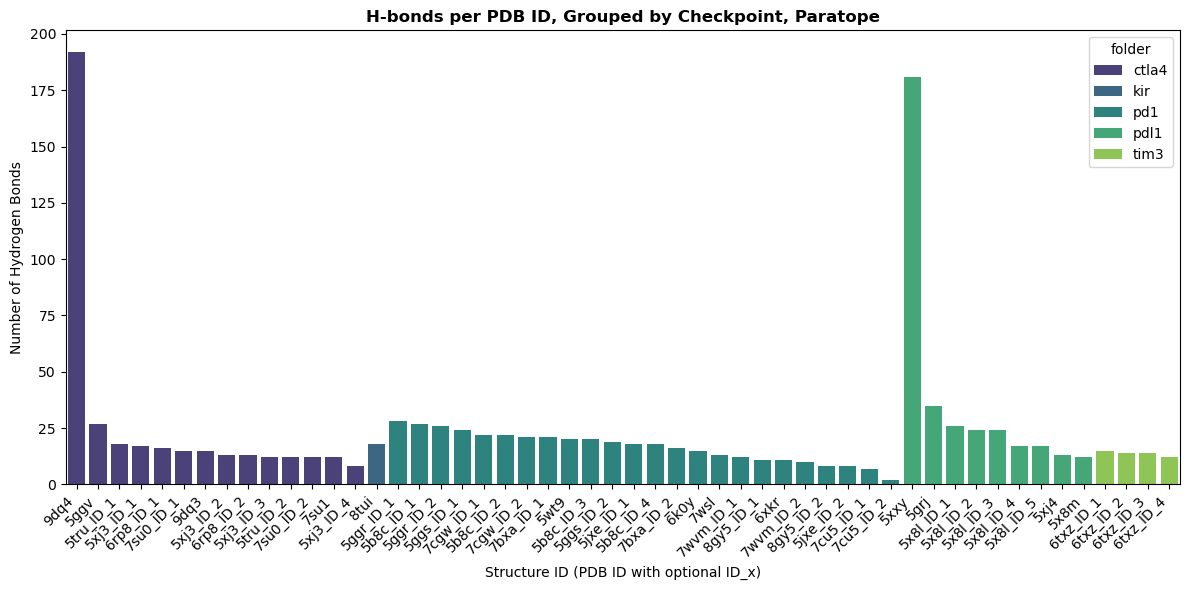

In [13]:
df_sorted_h = df_struc_info.sort_values(by=["folder", "num_filtered_hbonds"], ascending=[True, False]).copy()

# Count how many times each pdb_id appears
id_frequencies = Counter(df_sorted_h["pdb_id"])
id_tracker = defaultdict(int)

# Build structure_id column
structure_ids = []

for pdb_id in df_sorted_h["pdb_id"]:
    if id_frequencies[pdb_id] == 1:
        structure_ids.append(pdb_id)
    else:
        id_tracker[pdb_id] += 1
        structure_ids.append(f"{pdb_id}_ID_{id_tracker[pdb_id]}")

df_sorted_h["structure_id"] = structure_ids

# Plotting (same as before)
plt.figure(figsize=(12, 6))
sns.barplot(data=df_sorted_h, x="structure_id", y="num_filtered_hbonds", hue="folder", dodge=False, palette="viridis")

plt.title(f"H-bonds per PDB ID, Grouped by Checkpoint, {section.capitalize()}")
plt.xlabel("Structure ID (PDB ID with optional ID_x)")
plt.ylabel("Number of Hydrogen Bonds")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig(f'plots/structural_analysis/{section.capitalize()}/{section}_h_bonds_per_PDB.pdf', bbox_inches='tight')
plt.show()

#### Barplot - Salt Bridges per PDB ID

findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: F

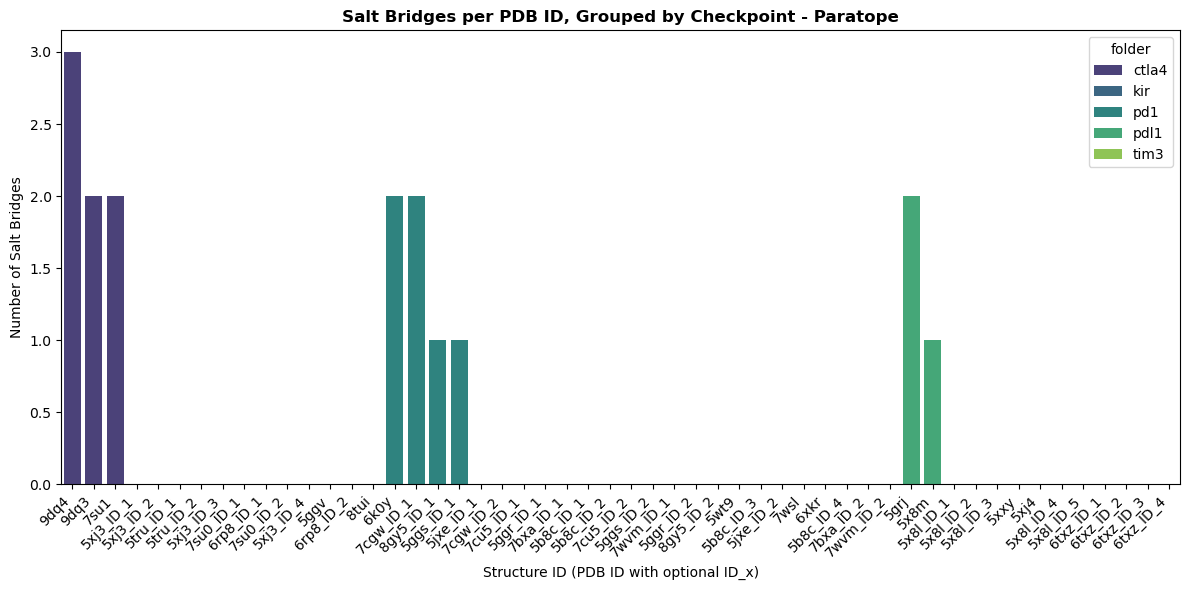

In [14]:

df_sorted_s = df_struc_info.sort_values(by=["folder", "num_salt_bridges"], ascending=[True, False]).copy()

# Count how many times each pdb_id appears
id_frequencies = Counter(df_sorted_s["pdb_id"])
id_tracker = defaultdict(int)

# Build structure_id column
structure_ids = []

for pdb_id in df_sorted_s["pdb_id"]:
    if id_frequencies[pdb_id] == 1:
        structure_ids.append(pdb_id)
    else:
        id_tracker[pdb_id] += 1
        structure_ids.append(f"{pdb_id}_ID_{id_tracker[pdb_id]}")

df_sorted_s["structure_id"] = structure_ids


# Plotting (same as before)
plt.figure(figsize=(12, 6))
sns.barplot(data=df_sorted_s, x="structure_id", y="num_salt_bridges", hue="folder", dodge=False, palette="viridis")

plt.title(f"Salt Bridges per PDB ID, Grouped by Checkpoint - {section.capitalize()}")
plt.xlabel("Structure ID (PDB ID with optional ID_x)")
plt.ylabel("Number of Salt Bridges")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig(f'plots/structural_analysis/{section.capitalize()}/{section}_salt_bridges_per_PDB.pdf', bbox_inches='tight')
plt.show() 



## Binding Score 

In [15]:
#normalizing with MinMax
scaler = MinMaxScaler()
df = pd.read_csv(f"data/structural_analysis/{section.capitalize()}/{section}_hbonds_salt_bridges_summary.csv")
features = df[["num_filtered_hbonds", "num_salt_bridges", f"buried_{section}_area"]].copy()
normalized = scaler.fit_transform(features)

df_norm = pd.DataFrame(normalized, columns=features.columns)
df_norm["pdb_id"] = df["pdb_id"]  

# Create a binding strength score
weights = {
    "num_filtered_hbonds": 0.4,
    "num_salt_bridges": 0.4,
    f"buried_{section}_area": 0.2
}

df_norm["binding_score"] = (
    df_norm["num_filtered_hbonds"] * weights["num_filtered_hbonds"] +
    df_norm["num_salt_bridges"] * weights["num_salt_bridges"] +
    df_norm[f"buried_{section}_area"] * weights[f"buried_{section}_area"]
)

In [16]:
# Sort the dataframe
df_sorted_bs = df_norm.sort_values(
    by=["binding_score", "num_filtered_hbonds", "num_salt_bridges", f"buried_{section}_area"],
    ascending=[False, False, False, False]  
).copy()
# Count appearances
id_frequencies = Counter(df_sorted_bs["pdb_id"])
id_tracker = defaultdict(int)

# Build unique structure IDs
structure_ids = []
for pdb_id in df_sorted_bs["pdb_id"]:
    if id_frequencies[pdb_id] == 1:
        structure_ids.append(pdb_id)
    else:
        id_tracker[pdb_id] += 1
        structure_ids.append(f"{pdb_id}_ID_{id_tracker[pdb_id]}")

# Add to DataFrame
df_sorted_bs["structure_id"] = structure_ids

### Barplot - Binding Score Composition per PDB ID

/var/folders/vf/ygq5vvrx3fbcsv9n_5277nmr0000gn/T/ipykernel_42590/2423592292.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  viridis = cm.get_cmap("viridis")
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font f

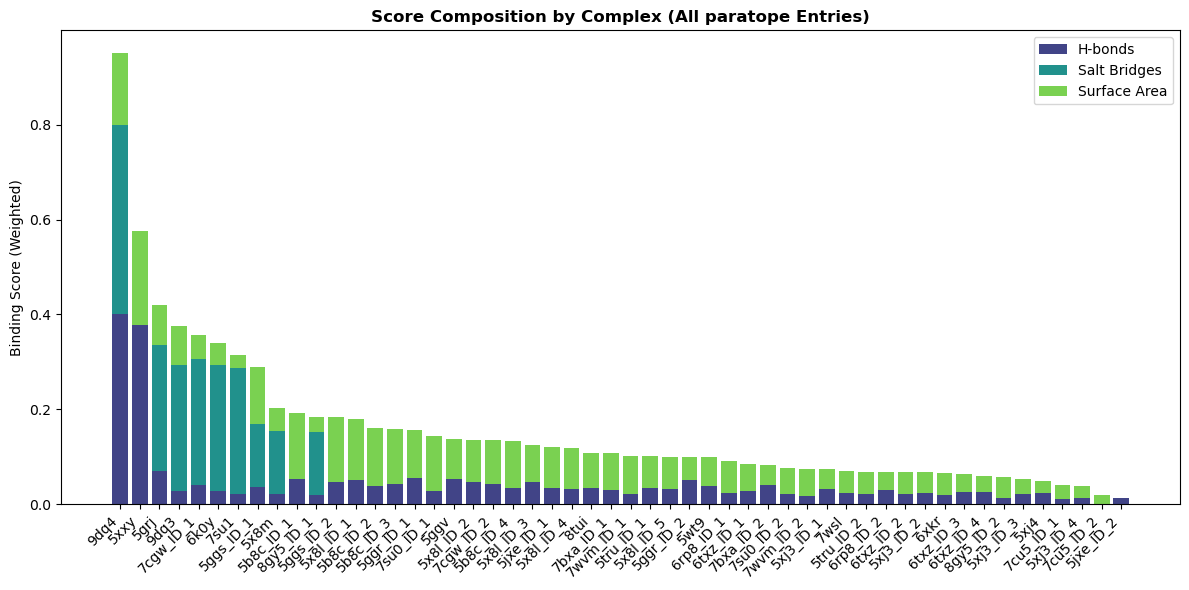

In [17]:
# Sort by binding score again
top = df_sorted_bs.sort_values("binding_score", ascending=False)

# Use viridis colormap
viridis = cm.get_cmap("viridis")
colors = viridis(np.linspace(0.2, 0.8, 3))

plt.figure(figsize=(12, 6))

# Plot H-bonds
plt.bar(
    top["structure_id"],
    top["num_filtered_hbonds"] * 0.4,
    label="H-bonds",
    color=colors[0],
    bottom=0
)

# Plot Salt Bridges
plt.bar(
    top["structure_id"],
    top["num_salt_bridges"] * 0.4,
    label="Salt Bridges",
    color=colors[1],
    bottom=top["num_filtered_hbonds"] * 0.4
)

# Plot Surface Area
plt.bar(
    top["structure_id"],
    top[f"buried_{section}_area"] * 0.2,
    label="Surface Area",
    color=colors[2],
    bottom=(top["num_filtered_hbonds"] + top["num_salt_bridges"]) * 0.4
)

plt.xticks(rotation=45, ha="right")
plt.ylabel("Binding Score (Weighted)")
plt.title(f"Score Composition by Complex (All {section} Entries)")
plt.legend()
plt.tight_layout()
plt.savefig(f"plots/structural_analysis/{section.capitalize()}/{section}_binding_affinity_score.pdf", bbox_inches="tight")
plt.show()




## Sequence Analysis

### Sequences Extraction

In [18]:
# Input settings
root_folder = "structures"
cutoff_distance = 5.0 
section = 'paratope'
bsa_threshold = 0.1  
results = []

# Ensure extracted_list is defined
if 'extracted_list' not in locals():
    extracted_list = []  # Format: [pdb_id, H_chain, L_chain, antigen_chain]

# Loop through all extracted entries
for pdb_id, h_chain, l_chain, ag_chain in extracted_list:
    pdb_path = None
    for dirpath, _, filenames in os.walk(root_folder):
        for file in filenames:
            if file.lower() == f"{pdb_id.lower()}.pdb":
                pdb_path = os.path.join(dirpath, file)
                break
        if pdb_path:
            break

    if not pdb_path:
        print(f"Skipping {pdb_id}: PDB file not found")
        continue
    else:
        print(f"Processing {pdb_id}...")

    cmd.reinitialize()
    cmd.load(pdb_path)

    # Define selections
    cmd.select("antibody", f"chain {h_chain}+{l_chain}")
    cmd.select("antigen", f"chain {ag_chain}")
    if section == 'paratope':
        cmd.select(section, f"antibody within {cutoff_distance} of antigen")
        interaction_chain = f"{h_chain}+{l_chain}"
    else:
        cmd.select(section, f"antigen within {cutoff_distance} of antibody")
        interaction_chain = ag_chain

    # Extract buried residues
    model = cmd.get_model(section)
    seen = set()
    buried_residues = []

    for atom in model.atom:
        res_id = (atom.chain, atom.resi, atom.resn)
        if res_id in seen or atom.resn == "HOH":
            continue
        seen.add(res_id)

        chain, resi, resn = res_id
        resid_sel = f"(chain {chain} and resi {resi})"

        try:
            # SASA before interaction
            cmd.create("temp_obj", f"chain {interaction_chain}")
            cmd.select("res_free", f"temp_obj and chain {chain} and resi {resi}")
            cmd.get_area("res_free", load_b=1)
            sasa_free = sum(a.b for a in cmd.get_model("res_free").atom)
            cmd.delete("temp_obj")
            cmd.delete("res_free")

            # SASA after interaction (in complex)
            cmd.get_area(resid_sel, load_b=1)
            sasa_complex = sum(a.b for a in cmd.get_model(resid_sel).atom)

            bsa = sasa_free - sasa_complex
            if bsa > bsa_threshold:
                buried_residues.append((int(resi), resn))
        except Exception as e:
            print(f"Error for {pdb_id} residue {chain}:{resi} → {e}")
            continue

    # Sort and convert to 1-letter sequence
    buried_residues.sort(key=lambda x: x[0])
    sequence = ''.join(seq1(resn) for _, resn in buried_residues)

    # Collect results
    results.append({
        "pdb_id": pdb_id,
        "H_chain": h_chain,
        "L_chain": l_chain,
        "antigen_chain": ag_chain,
        f"{section}_sequence": sequence,
        "folder": os.path.basename(dirpath)
    })

# Convert to DataFrame
df_seq = pd.DataFrame(results)

# Assign structure_id
df_seq = df_seq.sort_values(by=["folder", f"{section}_sequence"], ascending=[True, False]).copy()
id_frequencies = Counter(df_seq["pdb_id"])
id_tracker = defaultdict(int)

structure_ids = []
for pdb_id in df_seq["pdb_id"]:
    if id_frequencies[pdb_id] == 1:
        structure_ids.append(pdb_id)
    else:
        id_tracker[pdb_id] += 1
        structure_ids.append(f"{pdb_id}_ID_{id_tracker[pdb_id]}")

df_seq["structure_id"] = structure_ids

# Define output path
output_dir = f"data/structural_analysis/{section.capitalize()}"
os.makedirs(output_dir, exist_ok=True)

# Path to existing structural features file
summary_path = os.path.join(output_dir, f"{section}_hbonds_salt_bridges_summary.csv")

# Load it
if os.path.exists(summary_path):
    df_features = pd.read_csv(summary_path)
else:
    raise FileNotFoundError(f"{summary_path} not found. Please run the structural analysis first.")

# Merge sequence info into the structural features DataFrame
merged = df_features.merge(df_seq[["pdb_id", f"{section}_sequence"]], on="pdb_id", how="left")

# Update existing file with sequence info only (no row duplication)
if os.path.exists(summary_path):
    df_summary = pd.read_csv(summary_path)
    df_update = df_seq[["pdb_id", f"{section}_sequence"]]
    df_summary = df_summary.merge(df_update, on="pdb_id", how="left")
    df_summary.to_csv(summary_path, index=False)
    print(f"✅ Updated sequence info in '{summary_path}'")
else:
    raise FileNotFoundError(f"{summary_path} not found. Please run the structural analysis first.")


# Save FASTA
with open(f"{output_dir}/{section}_sequences.fasta", "w") as f:
    for _, row in df_seq.iterrows():
        f.write(f">{row['structure_id']}\n{row[f'{section}_sequence']}\n")


print(f"BSA-filtered sequences saved to CSV and FASTA.")

df_sorted_seq = df_seq.sort_values(by=["folder", f"{section}_sequence"], ascending=[True, False]).copy()


Processing 5xj3...
Processing 5jxe...
Processing 5x8l...
Processing 7cgw...
Processing 5xj3...
Processing 7cu5...
Processing 5x8l...
Processing 6txz...
Processing 6k0y...
Processing 5x8l...
Processing 5ggr...
Processing 5tru...
Processing 7bxa...
Processing 5b8c...
Processing 5b8c...
Processing 5x8m...
Processing 5grj...
Processing 5tru...
Processing 7cu5...
Processing 8gy5...
Processing 5ggs...
Processing 5xxy...
Processing 5xj3...
Processing 5ggs...
Processing 7su0...
Processing 9dq4...
Processing 6txz...
Processing 6rp8...
Processing 7su0...
Error for 7su0 residue I:52A → invalid literal for int() with base 10: '52A'
Processing 7wvm...
Processing 5ggr...
Processing 5xj3...
Processing 8tui...
Processing 6txz...
Processing 9dq3...
Processing 8gy5...
Processing 5ggv...
Processing 7su1...
Processing 6rp8...
Processing 5wt9...
Processing 5b8c...
Processing 5jxe...
Processing 7cgw...
Processing 7wsl...
Processing 6xkr...
Processing 5b8c...
Processing 7bxa...
Processing 5xj4...
Processing 

### Heatmap - Sequence Identity 

In [19]:
# Load sequences
records = list(SeqIO.parse(f"data/structural_analysis/{section.capitalize()}/{section}_sequences.fasta", "fasta"))

# Initialize identity matrix
matrix = []

# Compare each pair
for r1 in records:
    row = []
    for r2 in records:
        alignments = pairwise2.align.globalxx(r1.seq, r2.seq) # Align two sequences (whole sequence)
        best = alignments[0]
        identity = best.score / max(len(r1.seq), len(r2.seq)) * 100  # identiy in % -> (number of matches) / (length of longer sequence) × 100
        row.append(round(identity, 2))
    matrix.append(row)

# Create a DataFrame
ids = [rec.id for rec in records]
df_identity = pd.DataFrame(matrix, index=ids, columns=ids)

# Save & show
df_identity.to_csv(f"data/structural_analysis/{section.capitalize()}/{section}_sequence_comparison_matrix.csv")
print(f" Sequence identity matrix saved to '{section}_sequence_comparison_matrix.csv'")
print(df_identity)


checkpoints = ['PD-1', 'PD-L1', 'CTLA-4', 'KIR', 'LAG3', 'TIM3']

pdb_ids = {
    'PD-1': pd1['pdb'].unique().tolist(), 
    'PD-L1': pdl1['pdb'].unique().tolist(),
    'CTLA-4': ctla4['pdb'].unique().tolist(),
    'KIR': kir['pdb'].unique().tolist(),
    'LAG3': lag3['pdb'].unique().tolist(),
    'TIM3': tim3['pdb'].unique().tolist(),
}

# Create mapping from PDB ID → Checkpoint
pdb_to_checkpoint = {}
for checkpoint, pdb_list in pdb_ids.items():
    for pdb in pdb_list:
        pdb_to_checkpoint[pdb.lower()] = checkpoint

# Update row and column labels using base PDB ID
def get_checkpoint_label(pdb_id):
    '''Get checkpoint label for a given PDB ID'''
    base_id = pdb_id.lower().split('_')[0]
    checkpoint = pdb_to_checkpoint.get(base_id)  
    return f"{checkpoint} | {pdb_id}"

df_identity = df_identity.copy()
df_identity.index = [get_checkpoint_label(p) for p in df_identity.index]
df_identity.columns = [get_checkpoint_label(p) for p in df_identity.columns]

df_identity

 Sequence identity matrix saved to 'paratope_sequence_comparison_matrix.csv'
           5tru_ID_1  6rp8_ID_1  6rp8_ID_2  5xj3_ID_1  5xj3_ID_2  5xj3_ID_3  \
5tru_ID_1     100.00      85.71      77.78      57.14      71.43      85.71   
6rp8_ID_1      85.71     100.00      77.78      57.14      71.43      85.71   
6rp8_ID_2      77.78      77.78     100.00      55.56      66.67      77.78   
5xj3_ID_1      57.14      57.14      55.56     100.00      83.33      71.43   
5xj3_ID_2      71.43      71.43      66.67      83.33     100.00      85.71   
5xj3_ID_3      85.71      85.71      77.78      71.43      85.71     100.00   
9dq4           38.46      30.77      38.46      30.77      38.46      38.46   
5tru_ID_2      55.56      55.56      77.78      44.44      55.56      66.67   
5xj3_ID_4      85.71      71.43      66.67      57.14      71.43      85.71   
5ggv           44.44      44.44      44.44      33.33      33.33      33.33   
9dq3           55.56      44.44      55.56      44.44 

,CTLA-4 | 5tru_ID_1,CTLA-4 | 6rp8_ID_1,CTLA-4 | 6rp8_ID_2,CTLA-4 | 5xj3_ID_1,CTLA-4 | 5xj3_ID_2,CTLA-4 | 5xj3_ID_3,CTLA-4 | 9dq4,CTLA-4 | 5tru_ID_2,CTLA-4 | 5xj3_ID_4,CTLA-4 | 5ggv,...,PD-L1 | 5xj4,PD-L1 | 5xxy,PD-L1 | 5x8l_ID_3,PD-L1 | 5x8l_ID_4,PD-L1 | 5x8m,PD-L1 | 5x8l_ID_5,TIM3 | 6txz_ID_1,TIM3 | 6txz_ID_2,TIM3 | 6txz_ID_3,TIM3 | 6txz_ID_4
CTLA-4 | 5tru_ID_1,100.00,85.71,77.78,57.14,71.43,85.71,38.46,55.56,85.71,44.44,...,28.57,25.00,40.00,36.36,42.86,44.44,33.33,42.86,42.86,42.86
CTLA-4 | 6rp8_ID_1,85.71,100.00,77.78,57.14,71.43,85.71,30.77,55.56,71.43,44.44,...,14.29,18.75,30.00,27.27,42.86,33.33,33.33,42.86,42.86,42.86
CTLA-4 | 6rp8_ID_2,77.78,77.78,100.00,55.56,66.67,77.78,38.46,77.78,66.67,44.44,...,33.33,31.25,50.00,45.45,44.44,55.56,44.44,44.44,33.33,44.44
CTLA-4 | 5xj3_ID_1,57.14,57.14,55.56,100.00,83.33,71.43,30.77,44.44,57.14,33.33,...,40.00,18.75,30.00,27.27,42.86,33.33,22.22,28.57,28.57,28.57
CTLA-4 | 5xj3_ID_2,71.43,71.43,66.67,83.33,100.00,85.71,38.46,55.56,71.43,33.33,...,33.33,25.00,40.00,36.36,42.86,44.44,33.33,28.57,42.86,28.57
CTLA-4 | 5xj3_ID_3,85.71,85.71,77.78,71.43,85.71,100.00,38.46,66.67,85.71,33.33,...,28.57,25.00,40.00,36.36,42.86,44.44,33.33,28.57,42.86,28.57
CTLA-4 | 9dq4,38.46,30.77,38.46,30.77,38.46,38.46,100.00,38.46,38.46,30.77,...,15.38,31.25,38.46,38.46,23.08,38.46,30.77,30.77,23.08,23.08
CTLA-4 | 5tru_ID_2,55.56,55.56,77.78,44.44,55.56,66.67,38.46,100.00,55.56,44.44,...,33.33,31.25,50.00,45.45,33.33,55.56,33.33,22.22,33.33,22.22
CTLA-4 | 5xj3_ID_4,85.71,71.43,66.67,57.14,71.43,85.71,38.46,55.56,100.00,33.33,...,28.57,25.00,40.00,36.36,42.86,44.44,33.33,28.57,42.86,28.57
CTLA-4 | 5ggv,44.44,44.44,44.44,33.33,33.33,33.33,30.77,44.44,33.33,100.00,...,22.22,31.25,30.00,36.36,33.33,44.44,44.44,44.44,44.44,55.56


/var/folders/vf/ygq5vvrx3fbcsv9n_5277nmr0000gn/T/ipykernel_42590/1677436481.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot_data = df_identity.applymap(lambda x: f"{int(x)}" if x >= 70 else "")


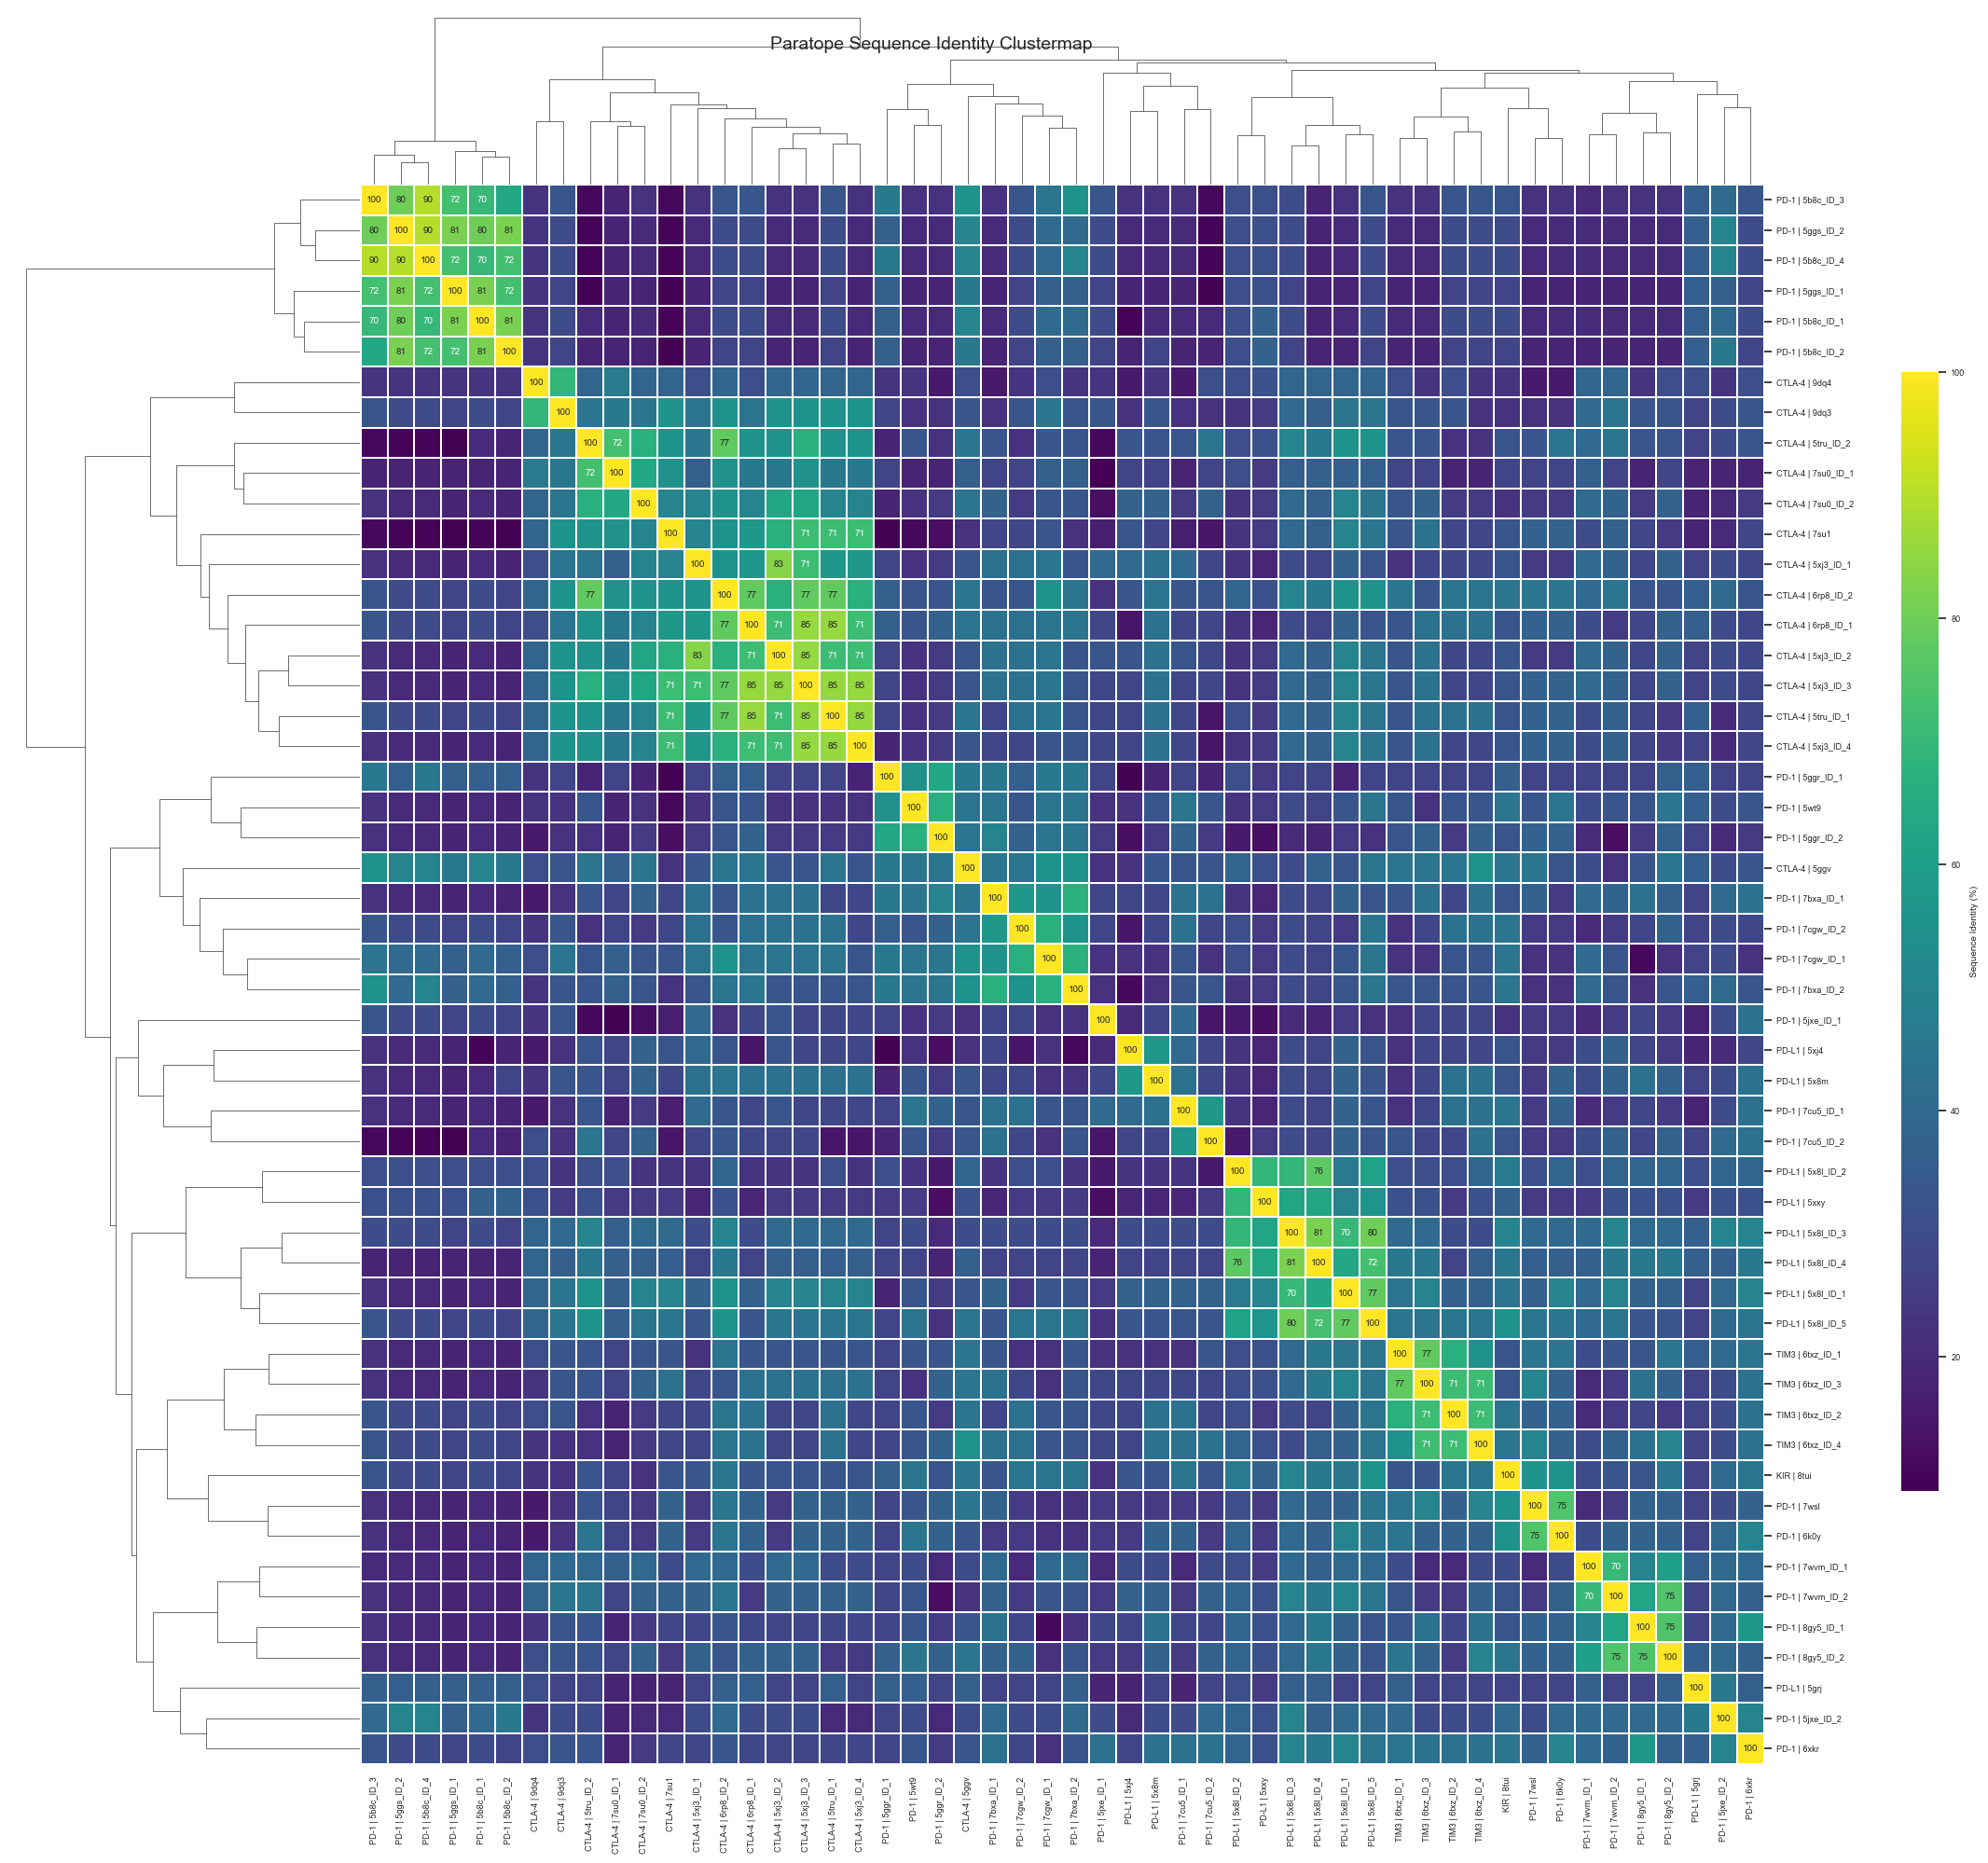

In [20]:
sns.set(font_scale=0.6)

# annotate only high identities
annot_data = df_identity.applymap(lambda x: f"{int(x)}" if x >= 70 else "")

g = sns.clustermap(
    df_identity,
    cmap="viridis",
    figsize=(20, 20),
    annot=annot_data,
    fmt="",
    linewidths=0.3,
    cbar_kws={
        "label": "Sequence Identity (%)",
        "shrink": 1.0,
        "aspect": 10,
        "pad": 0.02
    },
    dendrogram_ratio=(.2, .1),
    xticklabels=True,
    yticklabels=True,
    cbar_pos=(1.02, 0.2, 0.02, 0.6)  # move right: 1.02 instead of 0.95
)

g.fig.suptitle(f"{section.capitalize()} Sequence Identity Clustermap", fontsize=14)
plt.savefig(f"plots/structural_analysis/{section.capitalize()}/{section}_clustermap.pdf", dpi=300, bbox_inches="tight")
plt.show()


### Barplot - Sequence Length per PDB ID

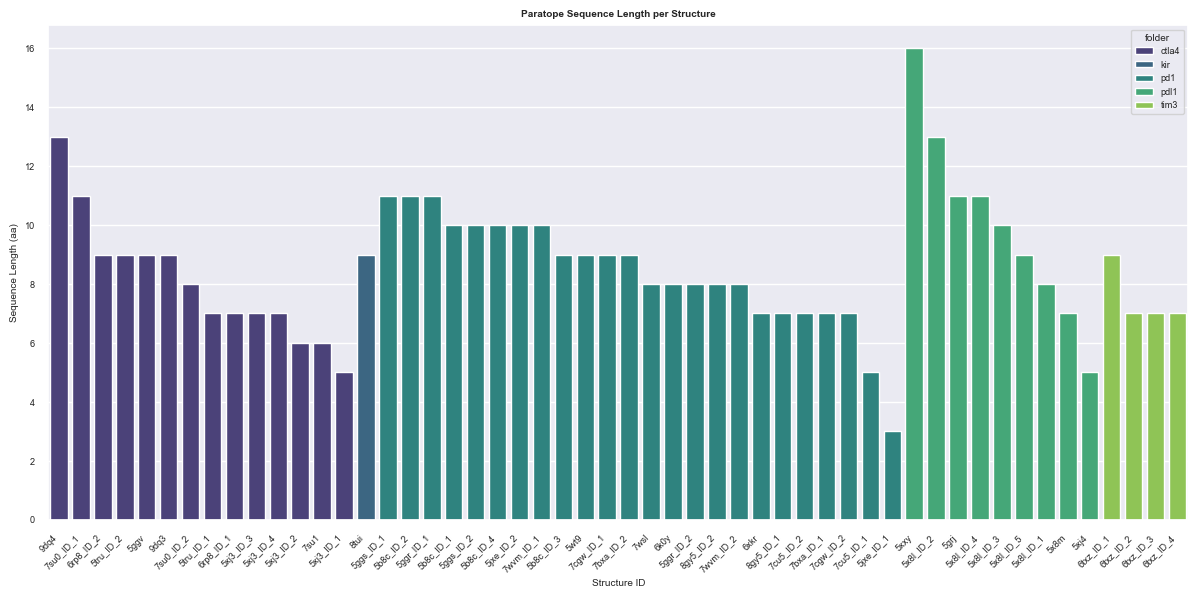

In [21]:
# Add column with sequence length
df_seq[f"{section}_length"] = df_seq[f"{section}_sequence"].str.len()

# Sort 
df_seq_sorted_by_length = df_seq.sort_values(by=["folder", f"{section}_length"], ascending=[True, False])

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=df_seq_sorted_by_length, x="structure_id", y=f"{section}_length", hue="folder", dodge=False, palette="viridis")

plt.title(f"{section.capitalize()} Sequence Length per Structure")
plt.xlabel("Structure ID")
plt.ylabel("Sequence Length (aa)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig(f"plots/structural_analysis/{section.capitalize()}/{section}_sequence_lengths.pdf", bbox_inches='tight')
plt.show()

In [28]:
# 1. Load data
base_path = f"data/structural_analysis/{section.capitalize()}"
summary_path = f"{base_path}/{section}_hbonds_salt_bridges_summary.csv"
df_struct = pd.read_csv(summary_path)

# 2. Create structure_id in df_struct
id_frequencies = Counter(df_struct["pdb_id"])
id_tracker = defaultdict(int)
structure_ids = []
for pdb_id in df_struct["pdb_id"]:
    if id_frequencies[pdb_id] == 1:
        structure_ids.append(pdb_id)
    else:
        id_tracker[pdb_id] += 1
        structure_ids.append(f"{pdb_id}_ID_{id_tracker[pdb_id]}")
df_struct["structure_id"] = structure_ids



# 3. Remove duplicates from binding score data
df_norm = df_norm.drop_duplicates(subset="pdb_id")

# 4. Merge additional data
# Get the new structure_id and sequence for each pdb_id
structure_info = df_sorted_seq[["pdb_id", "structure_id", f"{section}_sequence"]]

# Merge structure_id and sequence into df_struct
df_struct = df_struct.merge(structure_info, on="pdb_id", how="left")
df_struct["structure_id"] = df_struct["structure_id_x"].combine_first(df_struct["structure_id_x"])
df_struct.drop(columns=["structure_id_x"], inplace=True)

df_struct[f"{section}_sequence_x"] = df_struct[f"{section}_sequence_x"].combine_first(df_struct.get(f"{section}_sequence_x"))

# Merge binding score
df_struct = df_struct.merge(df_norm[["pdb_id", "binding_score"]], on="pdb_id", how="left")

# 5. Save updated summary
df_struct.to_csv(summary_path, index=False)
print(f"Summary file updated in place at '{summary_path}'")



Summary file updated in place at 'data/structural_analysis/Paratope/paratope_hbonds_salt_bridges_summary.csv'


In [29]:
df_struct

,pdb_id,H_chain,L_chain,antigen_chain,buried_paratope_area,num_filtered_hbonds,num_salt_bridges,folder,paratope_sequence_x,structure_id_y,paratope_sequence_y,structure_id,binding_score
0,5xj3,D,E,F,754.822449,17,0,ctla4,YNYSW,5xj3_ID_1,YNYSW,5xj3_ID_1,0.073501
1,5xj3,D,E,F,754.822449,17,0,ctla4,YNYSW,5xj3_ID_2,YNYGSW,5xj3_ID_1,0.073501
2,5xj3,D,E,F,754.822449,17,0,ctla4,YNYSW,5xj3_ID_3,YNYGSSW,5xj3_ID_1,0.073501
3,5xj3,D,E,F,754.822449,17,0,ctla4,YNYSW,5xj3_ID_4,QYYGSSW,5xj3_ID_1,0.073501
4,5xj3,D,E,F,754.822449,17,0,ctla4,YNYGSW,5xj3_ID_1,YNYSW,5xj3_ID_2,0.073501
...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,5x8l,F,K,A,1111.904175,17,0,pdl1,DWSYGSYYW,5x8l_ID_1,WWSYGSYW,5x8l_ID_25,0.135876
414,5x8l,F,K,A,1111.904175,17,0,pdl1,DWSYGSYYW,5x8l_ID_2,SSDWSYSTYYRWP,5x8l_ID_25,0.135876
415,5x8l,F,K,A,1111.904175,17,0,pdl1,DWSYGSYYW,5x8l_ID_3,SDWSYGSYRW,5x8l_ID_25,0.135876
416,5x8l,F,K,A,1111.904175,17,0,pdl1,DWSYGSYYW,5x8l_ID_4,SDWSYGSTYWP,5x8l_ID_25,0.135876


In [30]:
df = pd.read_csv('data/structural_analysis/Paratope/paratope_hbonds_salt_bridges_summary.csv')

# Keep only the *last* occurrence of each structure_id
df_clean = df.drop_duplicates(subset='structure_id', keep='last')

# Save the cleaned CSV
df_clean.to_csv("data/structural_analysis/Paratope/paratope_hbonds_salt_bridges_summary.csv", index=False)